In [1]:
import sys
sys.path.append('./')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import os
from typing import Union

In [3]:
import torch as th
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

In [4]:
from dataset import ImageDataset, DataModule
from config import Config
import tokenizer
import utils
import model

In [5]:
df = pd.read_csv(os.path.join(Config.data_dir, 'Train.csv'), nrows=1000)
tok = tokenizer.Tokenizer()
dm = DataModule(df=df, tokenizer=tok)
dm.setup()

for data in dm.val_dataloader():
    images = data['img']
    labels = data['label']
    print(images.shape)
    print(labels.shape)
    break

INFO:root:Training on 800 and validating on 200


torch.Size([64, 3, 90, 282])
torch.Size([64, 10])


In [6]:
tfms = transforms.Compose([
    transforms.Resize(size=(Config.img_H, Config.img_W)),
])
net = model.Model(pretrained=True, transform=tfms).cuda()
# print(model)

INFO:root:Using resnet18 as features extractor


In [7]:
for batch_idx, data in enumerate(dm.val_dataloader()):
    images = data['img'].cuda()
    labels = data['label'].cuda()
    log_probs, beam_results, out_lens, loss = net(inputs=images,
                                                targets=labels)
    
    pred_ids, pred_texts, target_texts = net.batch_decode(
                                                            tokenizer=tok,
                                                            beam_results=beam_results,
                                                            out_lens=out_lens,
                                                            targets=labels,
                                                            select_index=0
    )

    
    image = utils.view_sample(images=images, labels=labels, predictions=pred_texts, return_image=True, show=False)
    
    break

[Logger] target tensor([61, 30, 23, 54, 61, 25, 15, 48,  5, 32])
[Logger] prediction 8QMMEa u68
[Logger] target tensor([61, 60, 60, 40, 43, 44, 27, 63, 55, 54])
[Logger] prediction bJLZZafSTN
[Logger] target tensor([43, 12, 61, 55, 34, 28, 60, 37, 60, 56])
[Logger] prediction Fx8g070S
[Logger] target tensor([38, 62, 58, 20, 38, 54, 21, 27,  4, 43])
[Logger] prediction lWg8t0EeHT
[Logger] target tensor([38, 13, 51, 15, 54, 48, 16, 25, 50, 50])
[Logger] prediction VSHtWiK0y
[Logger] target tensor([60, 62, 53, 35, 41, 59, 23, 31, 55, 16])
[Logger] prediction QPrOruBM
[Logger] target tensor([31, 38,  7, 22, 54, 39, 12,  2,  9, 63])
[Logger] prediction Iw qJ0oHEx
[Logger] target tensor([50,  9, 18, 34, 20, 30,  6, 59, 20,  6])
[Logger] prediction V4LlrLYEY
[Logger] target tensor([57, 55, 53, 37, 39, 32, 56, 17, 29, 53])
[Logger] prediction zwOLtz7D
[Logger] target tensor([44, 36, 62,  4, 56, 11, 63, 19, 18, 29])
[Logger] prediction NHPwr2Tyoo
[Logger] target tensor([ 9, 17, 18, 44, 20, 62, 

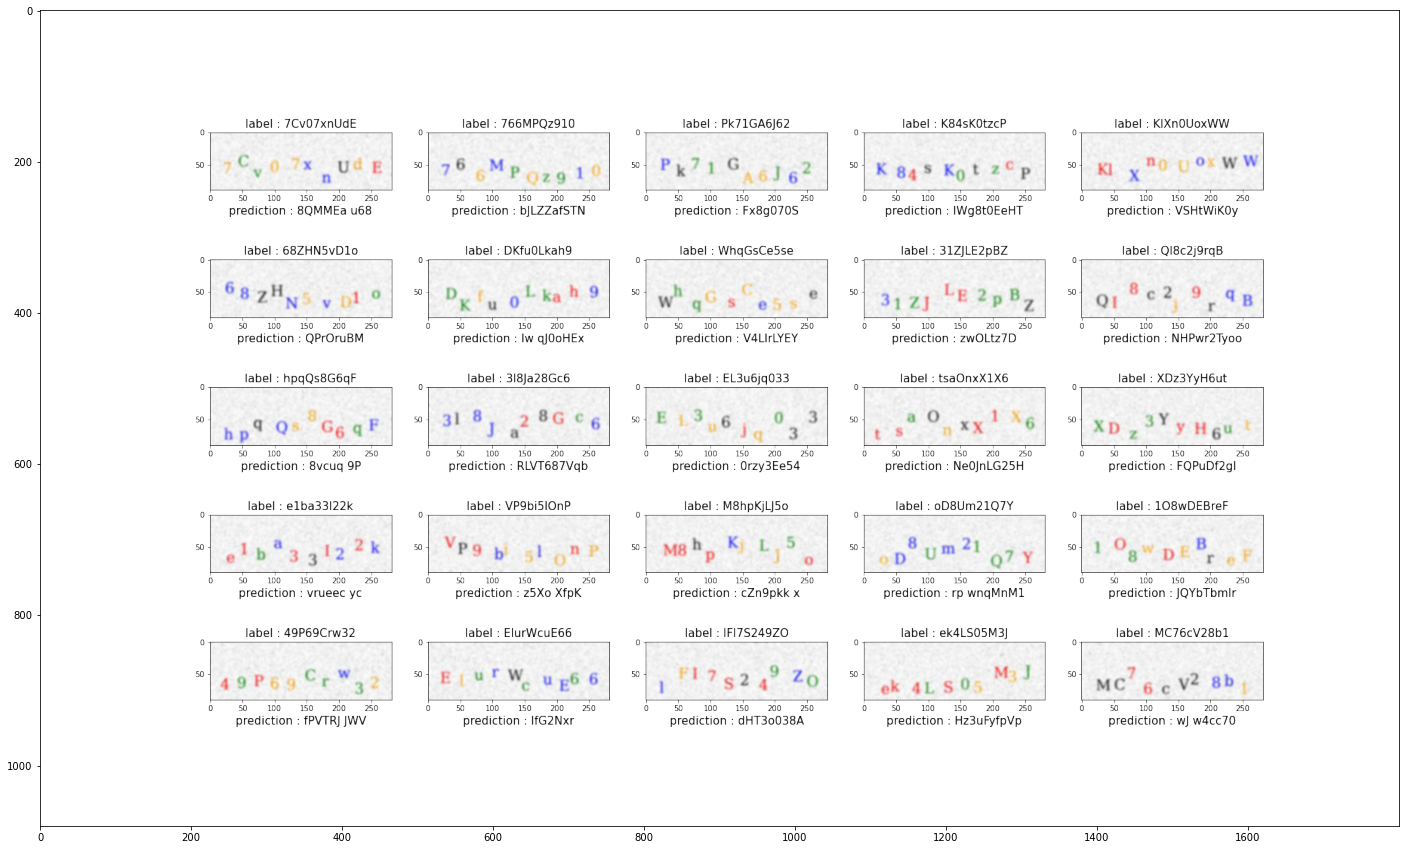

In [8]:
plt.figure(figsize=(25, 15))
plt.imshow(image)
plt.show()

writer = SummaryWriter(log_dir=os.path.join(Config.logs_dir, 'plots'))

writer.add_image(tag='predictions_grid', img_tensor=np.array(image), dataformats='HWC')